
# Ethical Implications

## 1. Lending and Discrimination

The [Equal Credit Opportunity Act (ECOA)](https://www.consumer.ftc.gov/articles/0347-your-equal-credit-opportunity-rights) is a federal law that prohibits lending entities (both institutions and people) from discriminating "on the basis of race, color, religion, national origin, sex, marital status, age," or because the prospective borrower receives public assistance. Lenders are, however, permitted to consider an applicant's "income, expenses, debts, and credit history" in evaluating the applicant's probability of repaying the debt to decide whether to accept or reject loan applications and to determine loan terms. Nevertheless, differential treatment by race, color, religion, national origin, sex, etc can still arise even when an institution or person is not explicitly discriminating based on those characteristics. Thus, we want to assess whether we see evidence of discrimination in LendingClub's acceptances and rejections of loan applications or in the terms it sets for accepted loans. In addition, we want to evaluate whether our proposed investing strategy results in differential treatment.

## 2. Literature Review

To inform our approach, we surveyed existing research of how predictive algorithms can result in discrimination and methods for addressing it.

**2A. Sweeney, L. "Discrimination in Online Ad Delivery". Communications of the ACM, May 2013, Vol. 56 No. 5, Pages 44-54.**

Sweeney's research presents evidence of discrimination in ad delivery on Google.com and Reuters.com on the basis of racially associated names. Using a chi-squared analysis, Sweeney found that running a search on a black-associated name was 25% more likely to get arrested-related ads compared to running a search on a white-associated name. All names used in the study were the full names of real people, roughly evenly split between professionals and "netizens" (i.e. people active on the internet - social media and blogs), and about one-third black and two-thirds white.

While disentangling the root cause of the discrimination fell outside the scope of the study, Sweeney's research clearly showcases the need to actively evaluate possibly unintended societal implications of the algorithms we put in place.

**2B. Datta, A., Tschantz, M.C., and Datta, A. "Automated Experiments on Ad Privacy Settings: A Tale of Opacity, Choice, and Discrimination". Proceedings on Privacy Enhancing Technologies 2015; 2015 (1):92–112.**

Datta et al. found evidence of gender discimination in employment-related searches by experimentally manipulating whether a simulated user specified male or female in Google's ad settings. Their results revealed that simulated male users were shown ads regarding coaching for high-paying careers more often than they were shown to simulated female users. They collected the ads results of 1000 simulated users - half male and half female - and trained a classifier predicting gender using the ad URLs and titles as the feature set. Their classifier used a 90-10 train-test split, and achieved 93% accuracy on the test set. The high predictive power of the classifier suggests gender discrimination in Google's employment-related ad results, and such discrimination can exacerbate the current gender pay gap.

With limited visibility into the details of Google's ad vending algorithm, the authors of this paper were also unable to isolate the mechanisms through which the discrimination is arising. But again, like Sweeney's research, it demonstrates algorithms, while not inherently subjective, can be discriminatory as well.

**2C. Angwin, J., Larson, J., Mattu, S., and Kirchner, L. "Machine Bias". ProPublica. May 23, 2016.**

In an article published on ProPublica, the authors found that COMPAS (Correctional Offender Management Profiling for Alternative Sanctions), one of the nation's most popular tools in criminal risk assessment, discriminates unfavorably toward black defendants but favorably toward white defendants. Although the prediction accuracy was about the same as the overall accuracy (61%) in both groups, COMPAS makes a systematically different kind of error depending on the defendant's race group. Specifically, black defendants were twice as likely as black defendants to fall victim to a false positive result, i.e. they did not reoffend within the next two years but were wrongly labelled as highly likely to reoffend (i.e. high risk). On the other hand, white defendants were twice as likely as black defendants to receive a false negative assessment, i.e. they did reoffend within the next two years but were incorrectly labelled as not very likely to reoffend (i.e. low risk). Using a logistic regression model, Angwin et al. found that bias against black defendants in COMPAS's predictions (higher risk scores) remains even after controlling for age, criminal history, future (actual) recidivism, charge degree, and gender.

## 3. Census Data Summary

Especially when machine-generated predictions carry significant life consequences, developers and scientists have a responsibility to ensure their algorithms do not create or exacerbate societal problems through disparate outcomes and impacts on different groups.

While LendingClub does not have the demographic data associated with each loan or loan application (either they don't collect it or they just don't make it publicly available), LendingClub does share the 3-digit zip codes of the borrowers and applicants. We leveraged these zip codes to tie high-level demographic information to the loan data.

After data processing (as described previously in the [Data Description](https://cs109group67.github.io/lendingclub/DataDescription.html) section), there are five records with missing data, likely originating from sparsely populated zip code areas. At least one 3-digit zip code area has a recorded population of zero. On average, the population is ~350k, with a household size of ~2.6 and a median income of $55k. For the average zip code area, the population is about evenly split between male and female, with the majority of the population White and having at least a High School education. (See **Table 1** below.)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
#formatting
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

#import statements
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import random

In [3]:
#read in the census data
census_df = pd.read_csv("data/census_data_clean_new.csv", index_col=False)

**Table 1. Selected Summary Statistics for Census Data**

In [4]:
#summarize census data
pd.set_option('float_format', '{:f}'.format)
census_df[['Population', 'Household_size', 'Avg_median_household_inc', 'Male_pct', 'White_pct', 'No_Diploma_pct']].describe()

,Population,Household_size,Avg_median_household_inc,Male_pct,White_pct,No_Diploma_pct
count,891.000000,886.000000,886.000000,886.000000,886.000000,885.000000
mean,357514.425365,2.657810,54876.389742,49.533976,71.255064,12.865526
std,391271.361292,0.306602,16378.655265,1.806755,20.720257,5.511241
min,0.000000,1.960550,10039.113879,42.618155,2.420546,0.873224
25%,116037.500000,2.493136,44655.485670,48.773422,58.467006,8.968413
50%,217838.000000,2.611310,51368.147218,49.374504,75.983965,11.838107
75%,451807.000000,2.761605,61534.292170,50.041174,89.283953,15.580997
max,3105203.000000,8.104651,184414.729328,88.256228,97.704745,38.063859


## 4. Exploratory Data Analysis

Leveraging zip codes, we explored whether there were demographic differences between loans that LendingClub accepted or rejected for its marketplace. We looked at the distributions of acceptances and rejections by demographic groups, on the basis of which federal law prohibits discrimination, in terms of both population count and as a percentage of the total population.

Visually, our exploratory data analysis did not suggest discrimination in either loan status or the grade assigned to issued loans. Between different sexes, races, household structures, and educational attainments, there was not a significant difference between either the accept-reject decision of loan applications or the resulting loan grade of the issued loans, as suggested by the large overlap in the histograms and boxplots in **Figures 1-5**.

In [5]:
#read in the cleaned loan data for accepted loans
loan_stats_df = pd.read_hdf("data/ls_keepzip.h5", "ls_keepzip")

In [6]:
#some processing of the accepted loan data
loan_cols_to_keep = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade',
                'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 
                'zip_code', 'dti']
accepted_df = loan_stats_df[loan_cols_to_keep]
accepted_df['accepted'] = 1

In [7]:
#read in the loan data for rejected loans
reject_stats_df = pd.read_pickle("data/RejectStats_clean.pkl")

In [8]:
#some processing of the rejected loan data
reject_cols_to_keep = ['Amount Requested', 'Risk_Score', 'Debt-To-Income Ratio', 'Zip Code', 'Employment Length']
rejected_df = reject_stats_df[reject_cols_to_keep]
rejected_df = rejected_df.rename(index=str, columns={"Amount Requested": "loan_amnt", 
                                                             "Risk_Score": "risk_score", 
                                                             "Debt-To-Income Ratio": "dti", 
                                                             "Zip Code": "zip_code", 
                                                             "Employment Length": "emp_length"})
rejected_df['dti'] = rejected_df['dti'].apply(lambda x: float(x[:-1]))
rejected_df['emp_length'].replace(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', 
                                 '7 years', '8 years', '9 years', '10+ years'], 
                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                inplace=True)
rejected_df['accepted'] = 0

In [9]:
#take a random sample of rejected_df of same size as accepted_df, as rejected_df is too large
rand_ind = np.random.choice(rejected_df.shape[0], accepted_df.shape[0], replace=False)
sample_rejected_df = rejected_df.iloc[rand_ind]

In [10]:
#Subset the common columns between the Loan Stats and Reject Stats (sample) datasets and combine
common_cols = ['loan_amnt', 'dti', 'zip_code', 'emp_length', 'accepted']
loan_df = accepted_df[common_cols].append(sample_rejected_df[common_cols])

In [11]:
#join loan data with census data by zip code
#use left join so that none of the loan records are dropped
loan_df = loan_df.rename(index=str, columns={"zip_code": "Zip"})
joined_df = pd.merge(loan_df,census_df, on='Zip', how='left')

In [12]:
#variable lists
level_vars = ['Population', 'Avg_median_household_inc', 'Households', 'Housing_Units']
race_vars_pct = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct', 'Islander_pct', 'Other_pct', 'Two_pct', 'Hispanic_pct']
race_vars_count = ['White', 'Black', 'Native', 'Asian', 'Islander', 'Other', 'Two', 'Hispanic']
sex_vars_pct = ['Female_pct', 'Male_pct']
sex_vars_count = ['Female', 'Male']
education_vars = ['No_Diploma_pct', 'High_School_pct', 'Some_College_pct', 
                  'Bachelors_Degree_pct', 'Graduate_Degree_pct']
household_vars_pct = ['Families_pct', 'Non_families_pct', 'Married_couple_families_pct','Single_parent_families_pct']
household_vars_count = ['Families', 'Non_families', 'Married_couple_families', 'Single_parent_families']

In [13]:
#function to plot histograms by accept/reject
def plot_acc_rej(var_list, figwidth, figheight):
    fig, axs = plt.subplots(int(np.ceil(len(var_list)/2)),2, figsize=(figwidth,figheight))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plot_list = axs.ravel()

    for i in np.arange(len(var_list)):
        rej_data = joined_df[joined_df['accepted']==0][var_list[i]]
        plot_list[i].hist(rej_data.dropna(), alpha=0.5, label='Rejected')
        
        acc_data = joined_df[joined_df['accepted']==1][var_list[i]]
        plot_list[i].hist(acc_data.dropna(), alpha=0.5, label='Accepted')

        plot_list[i].set_title("Histogram of {} by Loan Application Status".format(var_list[i]))
        plot_list[i].legend(loc='best')


    plt.show()

**Figure 1. Distributions of Loan Acceptances and Rejections by Populousness and Income**

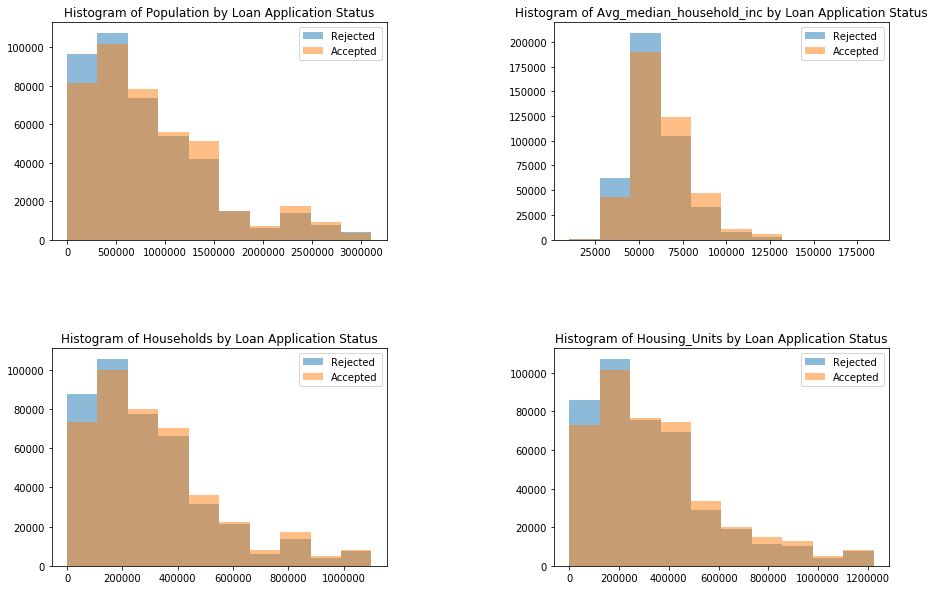

In [14]:
plot_acc_rej(level_vars, 15, 10)

Looking at the distributions of acceptances versus rejections by Population size, count of Households, and count of Housing Units, we observe a slight favoring of more populous areas for loan acceptances. Unsurprisingly, we also see that compared to the rejected loans, the accepted loans came from applicants in areas with higher median income.

**Figure 2A. Histograms: Distributions of Loan Acceptances and Rejections by Sex (Count and Percent of Total Population)**

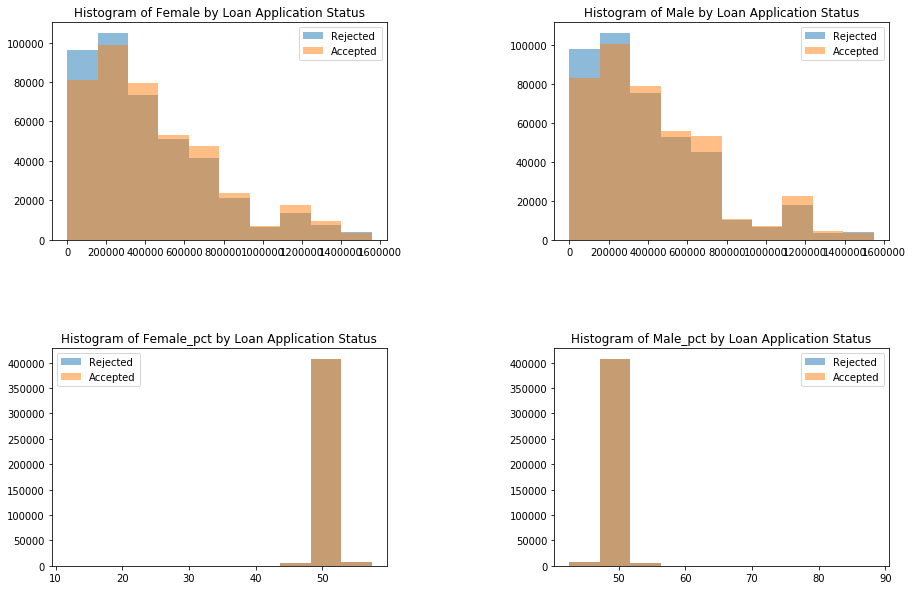

In [15]:
plot_acc_rej(sex_vars_count+sex_vars_pct, 15, 10)

**Figure 2B. Boxplots: Distributions of Loan Acceptances and Rejections by Sex (Count and Percent of Total Population)**

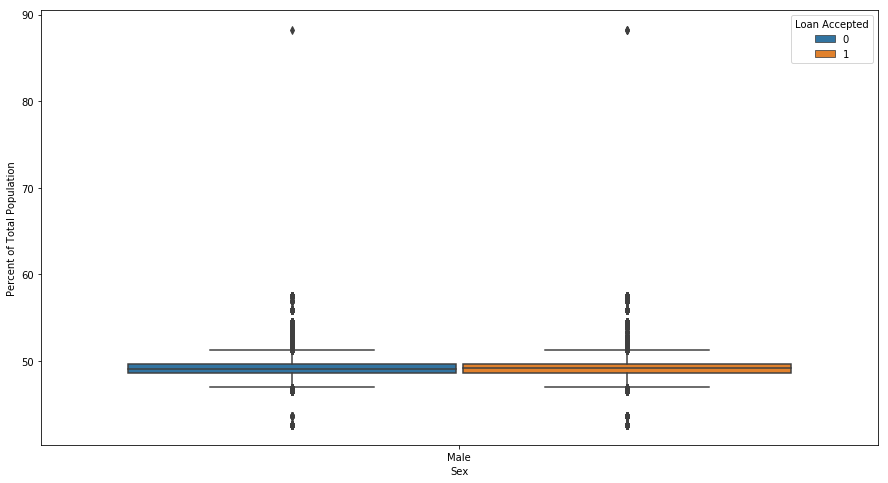

In [16]:
sex_df = pd.melt(joined_df[['Male_pct', 'accepted']].rename(index=str, columns={"Male_pct": "Male", "accepted": "Loan Accepted"}), 
        id_vars=['Loan Accepted'], value_vars=['Male'], 
        var_name='Sex', value_name='Percent of Total Population')
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Sex", y="Percent of Total Population", data=sex_df, hue="Loan Accepted")

**Figure 3A. Histograms: Distributions of Loan Acceptances and Rejections by Race (Count and Percent of Total Population)**

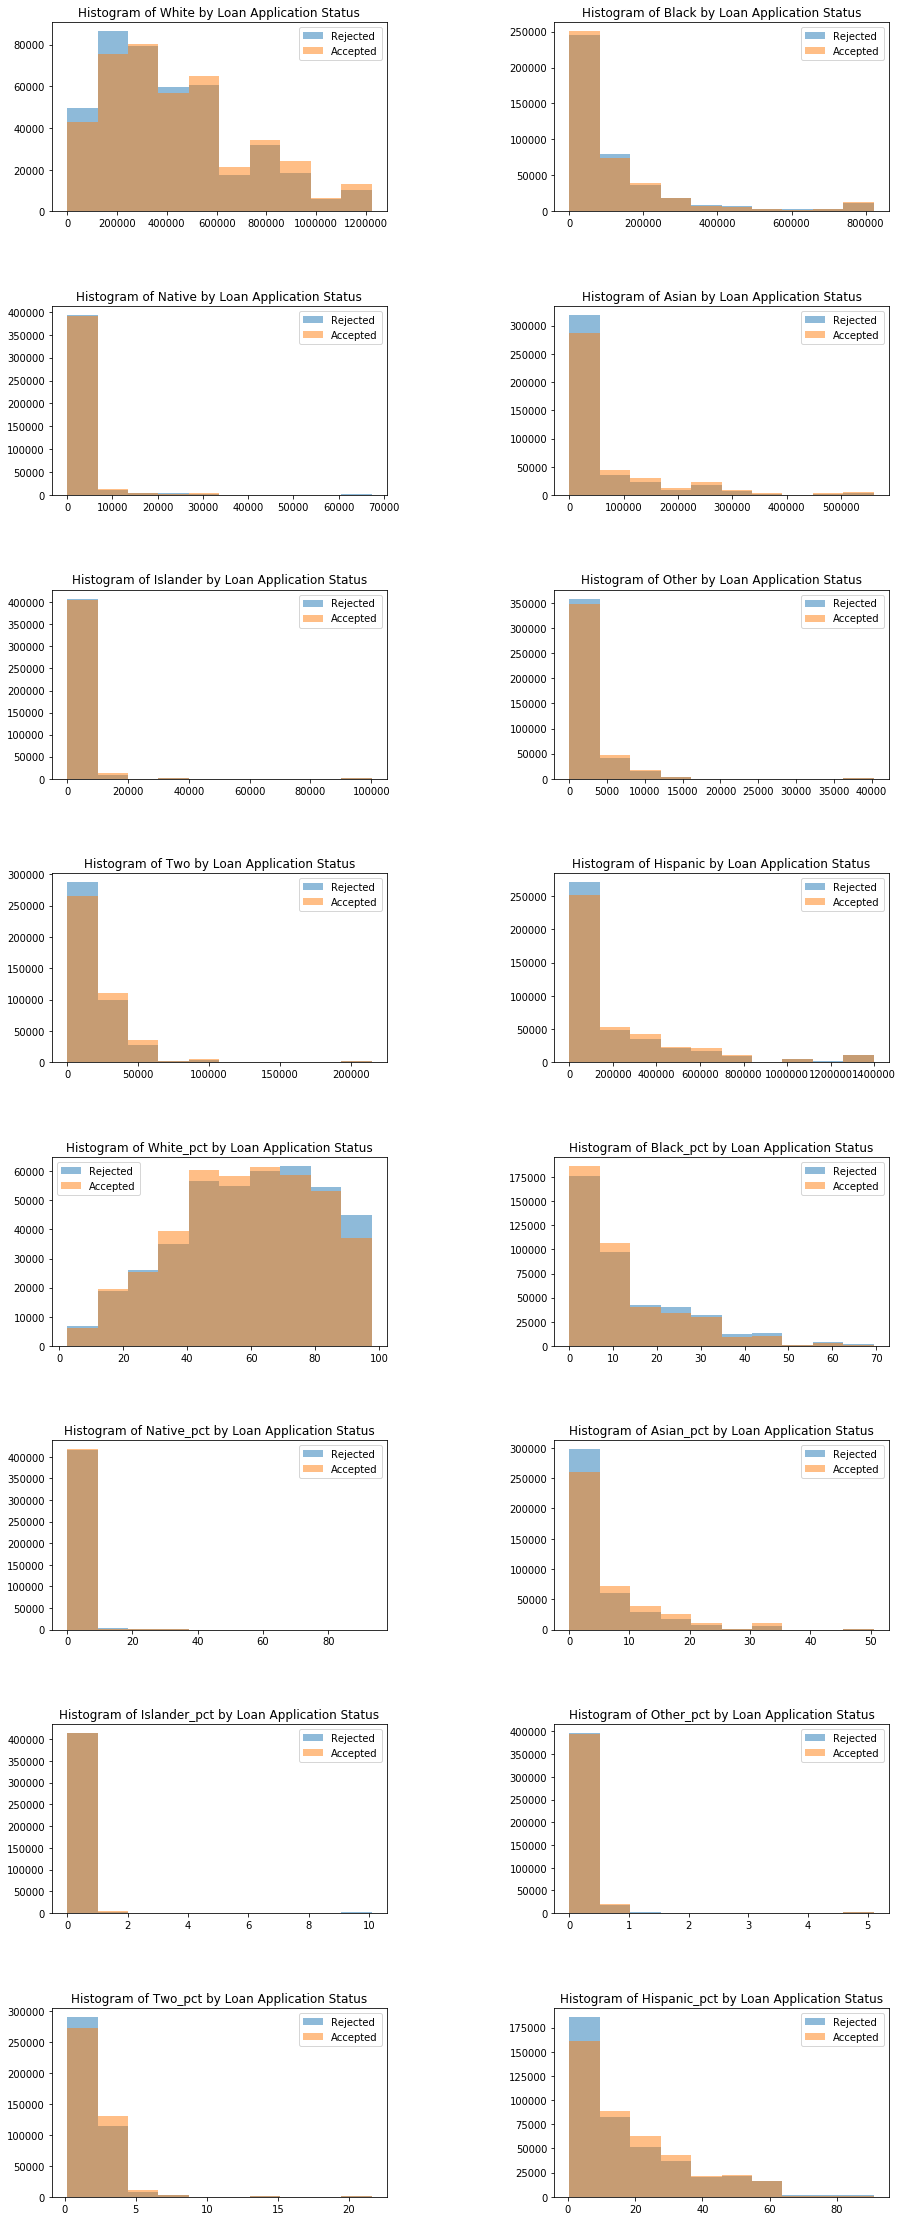

In [17]:
plot_acc_rej(race_vars_count+race_vars_pct, 15, 40)

**Figure 3B. Boxplots: Distributions of Loan Acceptances and Rejections by Race (Count and Percent of Total Population)**

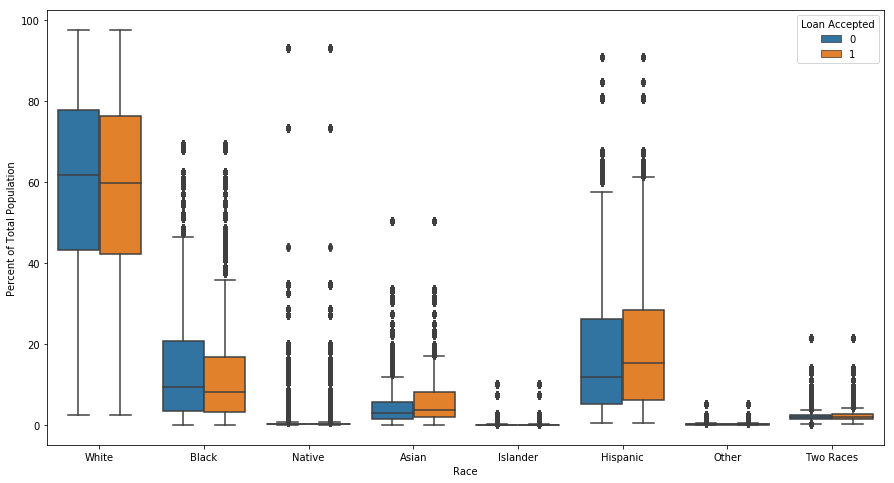

In [18]:
race_df = pd.melt(joined_df[race_vars_pct + ['accepted']].rename(index=str, 
                                           columns={"White_pct": "White", 
                                                    "Black_pct": "Black", 
                                                    "Native_pct": "Native", 
                                                    "Asian_pct": "Asian", 
                                                    "Islander_pct": "Islander", 
                                                    "Hispanic_pct": "Hispanic",
                                                    "Other_pct": "Other", 
                                                    "Two_pct": "Two Races", 
                                                    "accepted": "Loan Accepted"}),
        id_vars=['Loan Accepted'], value_vars=['White', 'Black', 'Native', 'Asian', 'Islander', 'Hispanic', 'Other', 'Two Races'], 
        var_name='Race', value_name='Percent of Total Population')  
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Race", y="Percent of Total Population", data=race_df, hue="Loan Accepted")

**Figure 4A. Histograms: Distributions of Loan Acceptances and Rejections by Household Structure and Marital Status (Count and Percent of Total Population)**

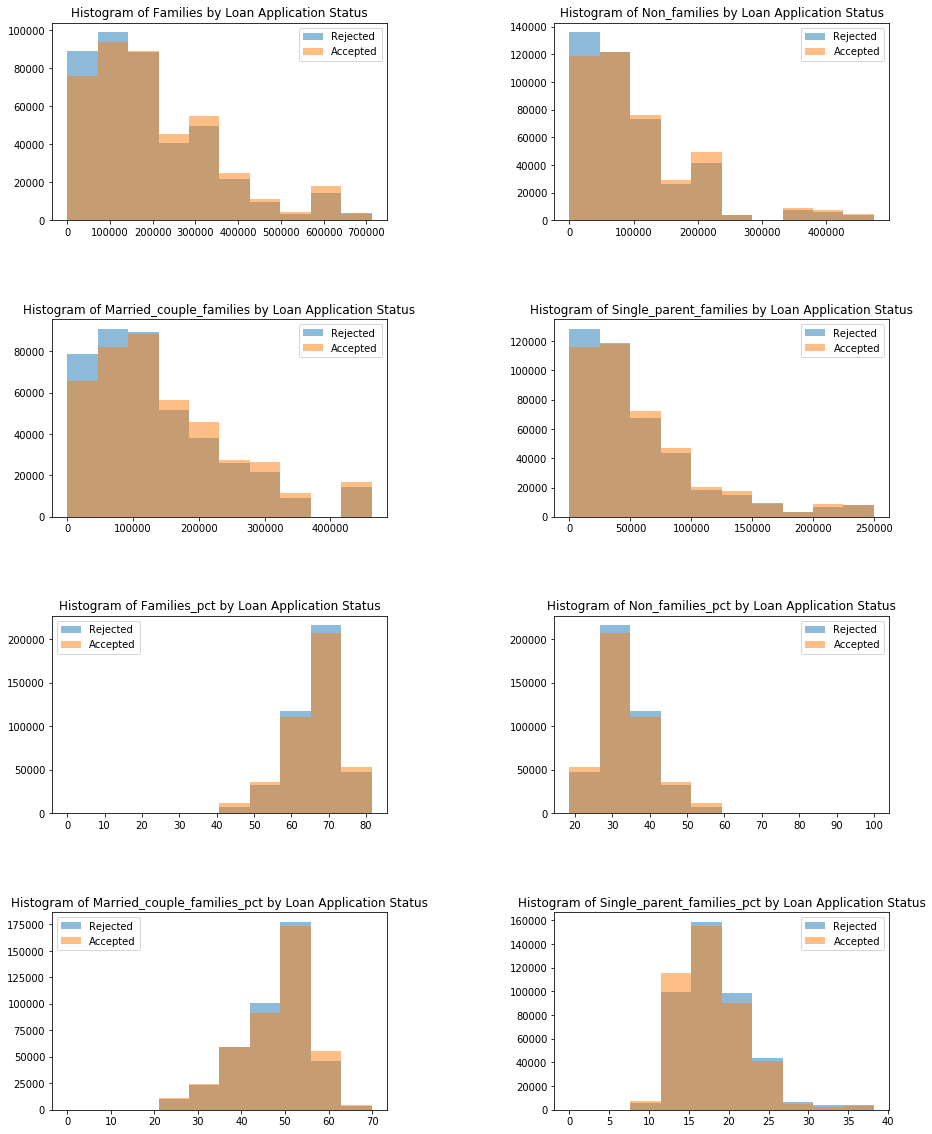

In [19]:
plot_acc_rej(household_vars_count+household_vars_pct, 15, 20)

**Figure 4B. Boxplots: Distributions of Loan Acceptances and Rejections by Household Structure and Marital Status (Count and Percent of Total Population)**

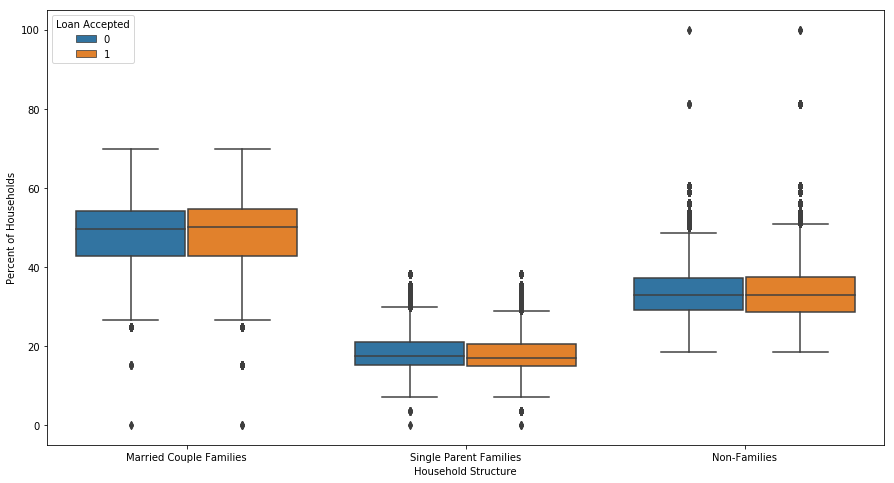

In [20]:
household_df = pd.melt(joined_df[['Married_couple_families_pct', 'Single_parent_families_pct', 'Non_families_pct', 'accepted']].rename(index=str, 
                                           columns={"Married_couple_families_pct": "Married Couple Families", 
                                                    "Single_parent_families_pct": "Single Parent Families", 
                                                    "Non_families_pct": "Non-Families", 
                                                    "accepted": "Loan Accepted"}),
        id_vars=['Loan Accepted'], value_vars=['Married Couple Families', 'Single Parent Families', 'Non-Families'], 
        var_name='Household Structure', value_name='Percent of Households') 
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Household Structure", y="Percent of Households", data=household_df, hue="Loan Accepted")

**Figure 5. Boxplots: Distributions of Loan Acceptances and Rejections by Educational Attainment (Count and Percent of Total Population)**

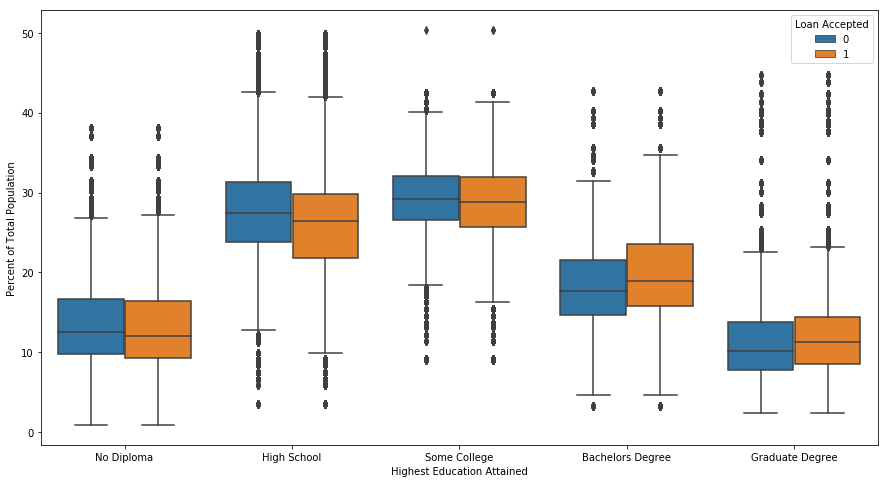

In [21]:
education_df = pd.melt(joined_df[education_vars + ['accepted']].rename(index=str, 
                                           columns={"No_Diploma_pct": "No Diploma", 
                                                    "High_School_pct": "High School", 
                                                    "Some_College_pct": "Some College", 
                                                    "Bachelors_Degree_pct": "Bachelors Degree", 
                                                    "Graduate_Degree_pct": "Graduate Degree", 
                                                    "accepted": "Loan Accepted"}),
        id_vars=['Loan Accepted'], value_vars=['No Diploma', 'High School', 'Some College', 'Bachelors Degree', 'Graduate Degree'], 
        var_name='Highest Education Attained', value_name='Percent of Total Population')      
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Highest Education Attained", y="Percent of Total Population", data=education_df, hue="Loan Accepted")

Further, of the loans that were accepted, we checked to see if there were noticeable differences in assigned loan grade by demographic groups. Loan grade will influence the interest rate the borrower is charged and whether or not investors want to fund the loan. Again, the data visualizations did not suggest discrimination. (See **Figures 6-9** below.)

In [22]:
#join accepted loan data with census data by zip code
accepted_df = accepted_df.rename(index=str, columns={"zip_code": "Zip"})
accepted_joined_df = pd.merge(accepted_df,census_df, on='Zip', how='left')

**Figure 6A. Distributions of Loan Grade by Sex (Percent of Total Population)**

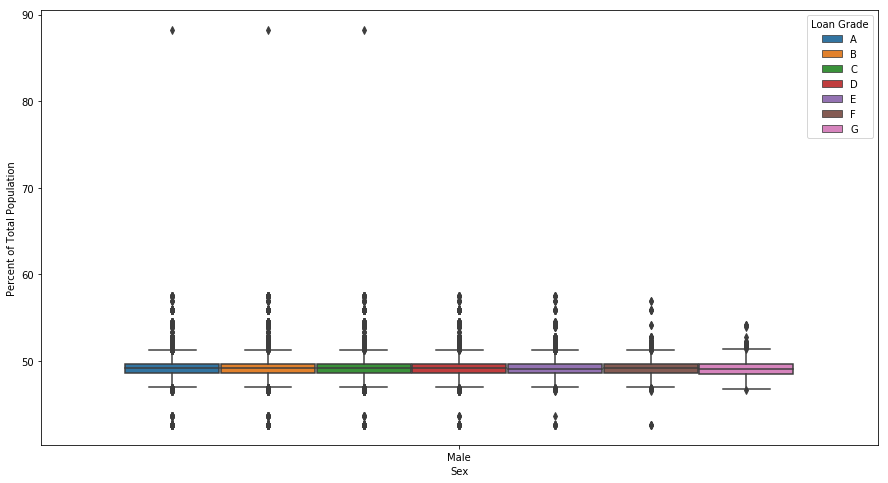

In [23]:
sgrade_df = pd.melt(accepted_joined_df[['Male_pct','grade']].rename(index=str, columns={"Male_pct": "Male", "grade": "Loan Grade"}), 
        id_vars=['Loan Grade'], value_vars=['Male'], 
        var_name='Sex', value_name='Percent of Total Population')
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Sex", y="Percent of Total Population", data=sgrade_df, hue="Loan Grade",
                hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

**Figure 6B. Distributions of Loan Grade by Sex (Population Count)**

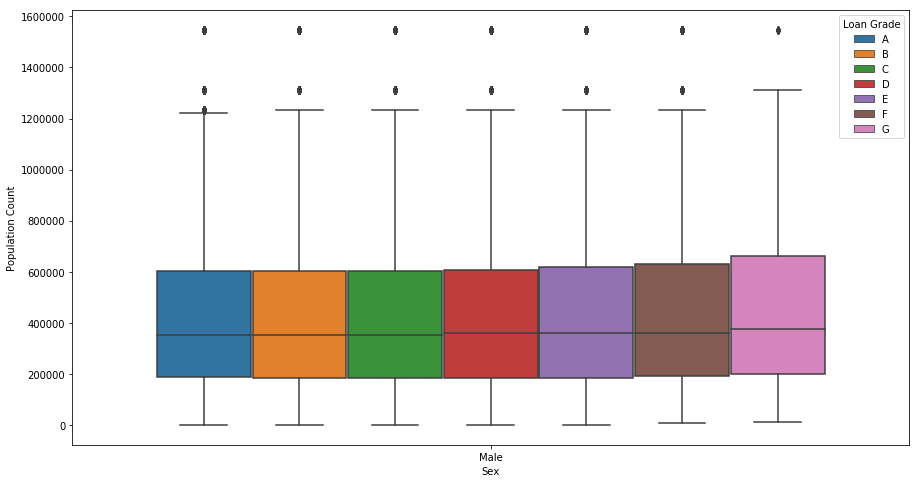

In [24]:
scgrade_df = pd.melt(accepted_joined_df[['Male','grade']].rename(index=str, columns={"Male": "Male", "grade": "Loan Grade"}), 
        id_vars=['Loan Grade'], value_vars=['Male'], 
        var_name='Sex', value_name='Population Count')
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Sex", y="Population Count", data=scgrade_df, hue="Loan Grade",
                hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

**Figure 7A. Distributions of Loan Grade by Race (Percent of Total Population)**

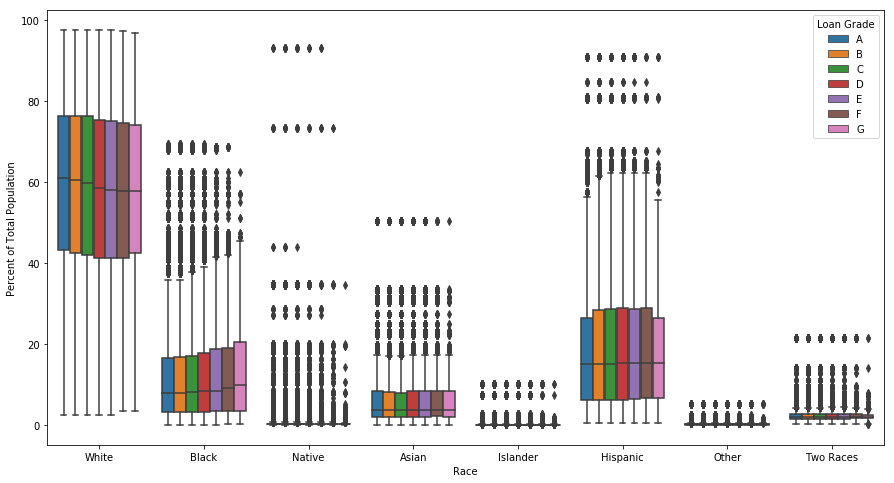

In [25]:
rgrade_df = pd.melt(accepted_joined_df[race_vars_pct + ['grade']].rename(index=str, 
                                           columns={"White_pct": "White", 
                                                    "Black_pct": "Black", 
                                                    "Native_pct": "Native", 
                                                    "Asian_pct": "Asian", 
                                                    "Islander_pct": "Islander", 
                                                    "Hispanic_pct": "Hispanic",
                                                    "Other_pct": "Other", 
                                                    "Two_pct": "Two Races", 
                                                    "grade": "Loan Grade"}),
        id_vars=['Loan Grade'], value_vars=['White', 'Black', 'Native', 'Asian', 'Islander', 'Hispanic', 'Other', 'Two Races'], 
        var_name='Race', value_name='Percent of Total Population')       
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Race", y="Percent of Total Population", data=rgrade_df, hue="Loan Grade",
                hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

**Figure 7B. Distributions of Loan Grade by Race (Population Count)**

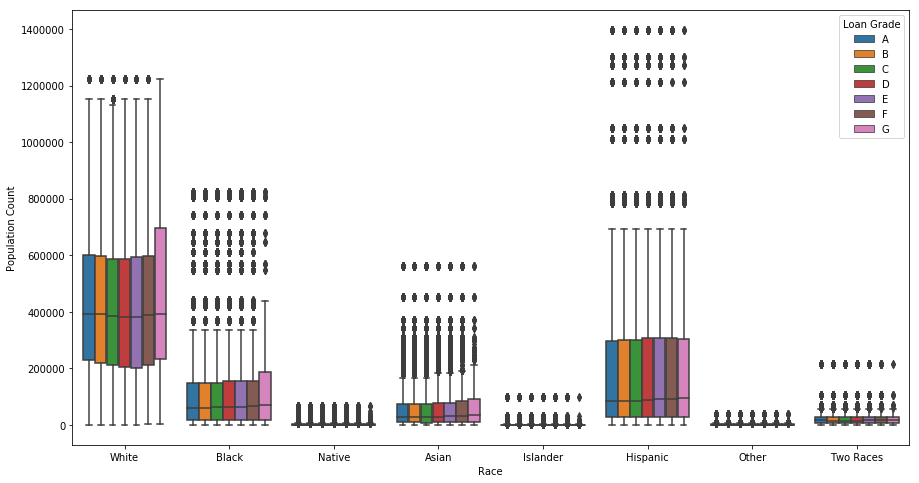

In [26]:
rcgrade_df = pd.melt(accepted_joined_df[race_vars_count + ['grade']].rename(index=str, 
                                           columns={"White": "White", 
                                                    "Black": "Black", 
                                                    "Native": "Native", 
                                                    "Asian": "Asian", 
                                                    "Islander": "Islander", 
                                                    "Hispanic": "Hispanic",
                                                    "Other": "Other", 
                                                    "Two": "Two Races", 
                                                    "grade": "Loan Grade"}),
        id_vars=['Loan Grade'], value_vars=['White', 'Black', 'Native', 'Asian', 'Islander', 'Hispanic', 'Other', 'Two Races'], 
        var_name='Race', value_name='Population Count')       
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Race", y="Population Count", data=rcgrade_df, hue="Loan Grade",
                hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

**Figure 8A. Distributions of Loan Grade by Household Structure and Marital Status (Percent of Total Households)**

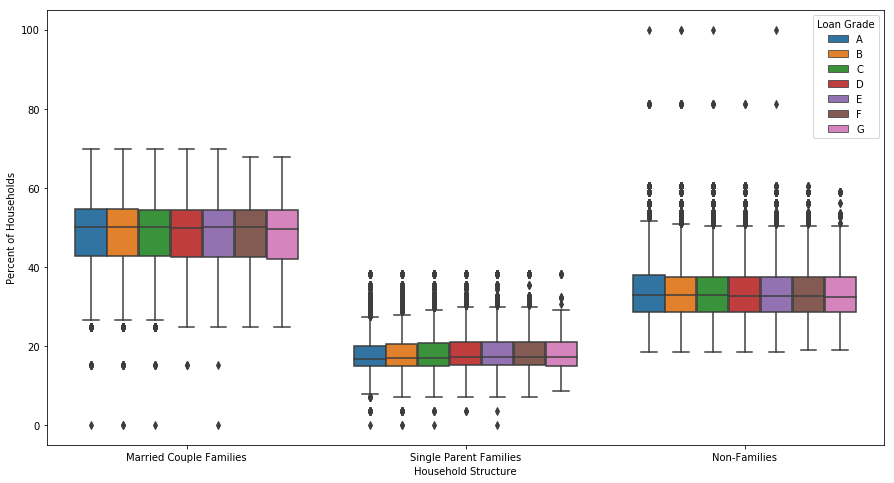

In [27]:
hgrade_df = pd.melt(accepted_joined_df[['Married_couple_families_pct', 'Single_parent_families_pct', 'Non_families_pct', 'grade']].rename(index=str, 
                                           columns={"Married_couple_families_pct": "Married Couple Families", 
                                                    "Single_parent_families_pct": "Single Parent Families", 
                                                    "Non_families_pct": "Non-Families", 
                                                    "grade": "Loan Grade"}),
        id_vars=['Loan Grade'], value_vars=['Married Couple Families', 'Single Parent Families', 'Non-Families'], 
        var_name='Household Structure', value_name='Percent of Households') 
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Household Structure", y="Percent of Households", data=hgrade_df, hue="Loan Grade",
                hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

**Figure 8B. Distributions of Loan Grade by Household Structure and Marital Status (Household Count)**

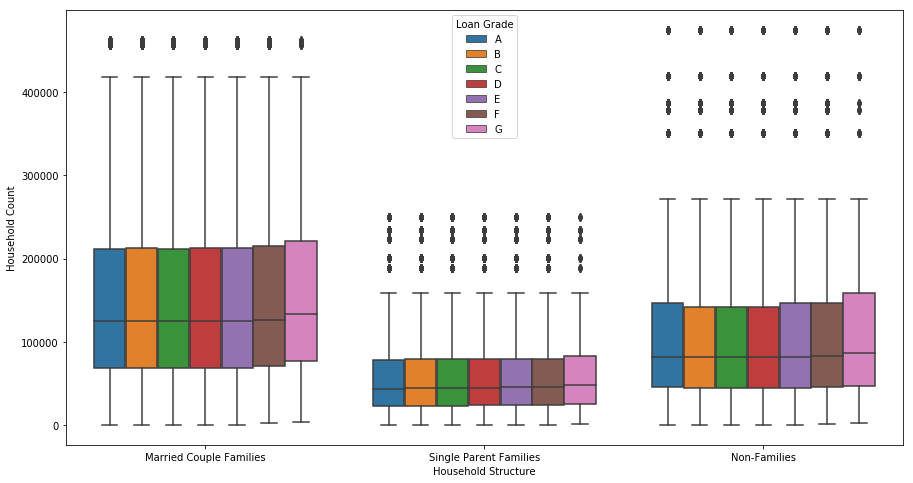

In [28]:
hcgrade_df = pd.melt(accepted_joined_df[['Married_couple_families', 'Single_parent_families', 'Non_families', 'grade']].rename(index=str, 
                                           columns={"Married_couple_families": "Married Couple Families", 
                                                    "Single_parent_families": "Single Parent Families", 
                                                    "Non_families": "Non-Families", 
                                                    "grade": "Loan Grade"}),
        id_vars=['Loan Grade'], value_vars=['Married Couple Families', 'Single Parent Families', 'Non-Families'], 
        var_name='Household Structure', value_name='Household Count') 
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Household Structure", y="Household Count", data=hcgrade_df, hue="Loan Grade",
                hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

**Figure 9. Distributions of Loan Grade by Educational Attainment (Percent of Total Population)**

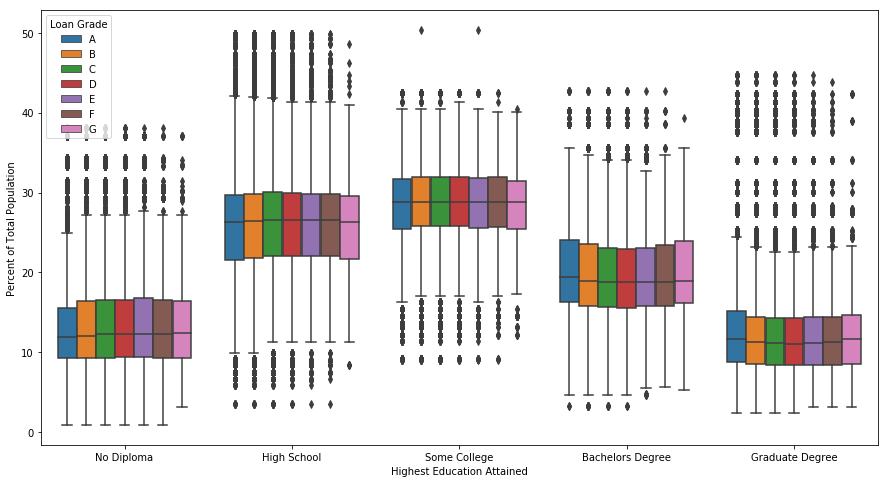

In [29]:
egrade_df = pd.melt(accepted_joined_df[education_vars + ['grade']].rename(index=str, 
                                           columns={"No_Diploma_pct": "No Diploma", 
                                                    "High_School_pct": "High School", 
                                                    "Some_College_pct": "Some College", 
                                                    "Bachelors_Degree_pct": "Bachelors Degree", 
                                                    "Graduate_Degree_pct": "Graduate Degree", 
                                                    "grade": "Loan Grade"}),
        id_vars=['Loan Grade'], value_vars=['No Diploma', 'High School', 'Some College', 'Bachelors Degree', 'Graduate Degree'], 
        var_name='Highest Education Attained', value_name='Percent of Total Population') 
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Highest Education Attained", y="Percent of Total Population", data=egrade_df, hue="Loan Grade",
                hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
ax.legend(title="Loan Grade", loc='upper left')
plt.show()

Going forward in the modelling, we chose to focus on the demographic measures as a percentage of the total population, because demographic information by zip code gets muddled by how populous the zip code is when using population counts. As we can see in the histograms in **Figures 1-4**, using counts makes the acceptance distributions slightly to the right of the rejection distributions for all demographic groups because accepted loans tended to come from more populous zip codes as shown in **Figure 1**, in the distributions by Population size.

## 5. Is there evidence of discrimination in LendingClub loans?

To evaluate whether certain demographic features might have influenced whether LendingClub accepted or rejected a loan application, we use random forests. For each tree in the forest, we recorded what the most important feature was, i.e. the feature on which the first split of that tree was made. Across all the trees in the forest, we created a frequency chart to assess relative feature importance (**Figure 10**).

In [30]:
#leave 'accepted' as the response variable
income_vars_pct = ['Less_than_24999_pct','From_25000_to_49999_pct','From_50000_to_74999_pct','From_75000_to_99999_pct','From_100000_to_149999_pct','From_150000_to_199999_pct','From_200000_or_more_pct']
income_vars_count = ['Less_than_24999','From_25000_to_49999','From_50000_to_74999','From_75000_to_99999','From_100000_to_149999','From_150000_to_199999','From_200000_or_more']
pct_predictors = ['loan_amnt']+['dti']+['emp_length']+education_vars+['Family_Poverty_pct']+['Unemployment_Rate_pct']+level_vars+race_vars_pct+sex_vars_pct+income_vars_pct+household_vars_pct
count_predictors = ['loan_amnt']+['dti']+['emp_length']+education_vars+['Family_Poverty_pct']+['Unemployment_Rate_pct']+level_vars+race_vars_count+sex_vars_count+income_vars_count+household_vars_count

In [31]:
def run_rf(rf_X, rf_y, n, depth):
    #split into training and test data
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(rf_X, rf_y, test_size=0.1)

    #train and test random forest classifier
    rf = RandomForestClassifier(n_estimators=n, max_depth=depth)
    rf.fit(X_train_rf, y_train_rf)
    rf_score_test = accuracy_score(y_test_rf, rf.predict(X_test_rf))
    print("The test accuracy of the RandomForestClassifier with max_depth {} and {} trees is {:.2f}."
          .format(depth_use, n_use, rf_score_test))
    return(rf)

In [35]:
#set rf parameters
n_use = 50
depth_use = 25

In [36]:
#set up data for the random forest classifier with the percent vars: accepted vs rejected loans
rf_pct_data = joined_df[pct_predictors + ['accepted']]
rf_pct_data.dropna(axis=0, inplace=True)
rf_pct_X = rf_pct_data.drop('accepted', axis=1)
rf_pct_y = rf_pct_data['accepted']

#set a random seed to keep results constant each time notebook is re-run
random.seed(2)
rf_pct = run_rf(rf_pct_X, rf_pct_y, n_use, depth_use)

The test accuracy of the RandomForestClassifier with max_depth 25 and 50 trees is 0.91.


In [37]:
#set up 2D array for storing counts
feature_list = list(rf_pct_X)[:-1]
top_features_pct = np.zeros(len(feature_list))

#count the top features from the random forest trees
for i in np.arange(1,n_use+1):
    feature_index = rf_pct.estimators_[i-1].tree_.feature[0]
    top_features_pct[feature_index] += 1
    
# set up df to record the top feature counts
top_features_pct_df = pd.DataFrame(data={'Top Feature Count': top_features_pct},
                                    index=feature_list)

**Figure 10. Feature Importance in Loan Acceptances vs. Rejections**

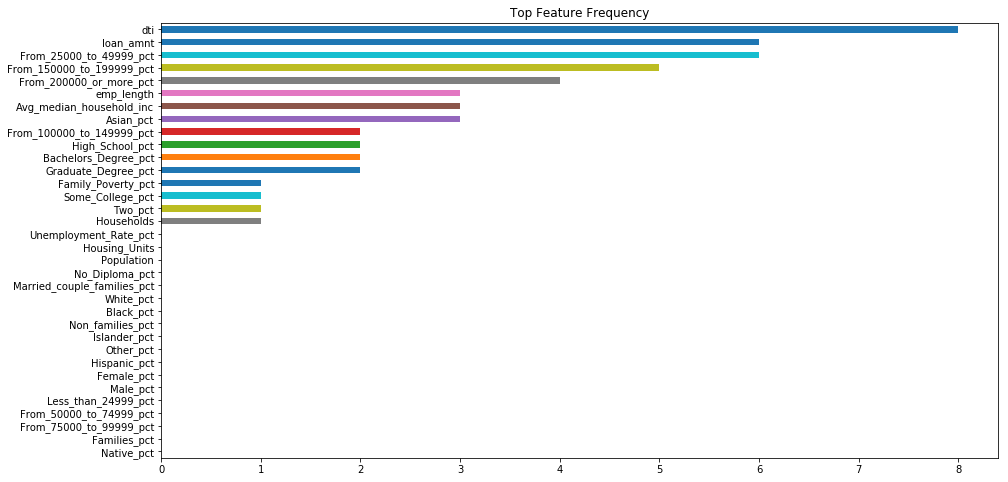

In [38]:
#top features for random forest trees
plt.figure(figsize=(15,8))
top_features_pct_df['Top Feature Count'].sort_values().plot(kind="barh")
plt.title("Top Feature Frequency")

plt.show()

The random forest was able to predicted whether the loan decision was accept or reject with 91% accuracy on a separate test set. As we can see from the feature importance chart above, many of the most important features are related to income and ability to pay back, such as debt-to-income ratio, the percentage of the population that falls in certain income brackets, employment length (indicating a stable source of income), and the percentage of the population that has at least a Bachelor's degree (which improves earning potential). Interestingly, the percentage of the population that is Asian is the fourth most important feature. Looking back at **Figure 3**, it seems that a higher Asian percentage of the population is favorable towards a loan acceptance.

In [39]:
loan_modelling_df = pd.read_hdf("data/ls_CLEAN_WITHZIP.h5", "ls_CLEAN_WITHZIP")
#join loan data with census data by zip code
#use inner join otherwise, nulls will be produced
loan_modelling_df = loan_modelling_df.rename(index=str, columns={"zip_code": "Zip"})
ols_df = pd.merge(loan_modelling_df,census_df.dropna(), on='Zip', how='inner')

The interest rate that a borrower is charged depends on the grade and sub-grade LendingClub assigns their loan. LendingClub determines the grade and sub-grade of the loan using a formula that considers credit score and credit risk. By the Equal Credit Opportunity Act (ECOA), lenders are also not permitted to discriminate loan terms on the basis of certain demographic group memberships. Thus, we investigated whether the demographic features in our dataset revealed a significant influence on loan sub-grade by conducting a linear regression. We removed some of the percent variables to reduce multi-collinearity, because summing all the percent variables of a certain demographic characteristic results in 100% (e.g. Male percent + Female percent). We replaced the income related variables in the Census dataset with the income data that was specific to each loan from the LoanStats dataset. We also included a select few variables that are related to credit score and credit risk, which LendingClub factors into loan grade and sub-grade assignment.

In [40]:
loan_vars_keep = ['annual_inc','earliest_cr_line','emp_length','loan_amnt','dti']

census_pct_keep = ['Population','High_School_pct','Some_College_pct','Bachelors_Degree_pct','Graduate_Degree_pct',
 'Family_Poverty_pct','Unemployment_Rate_pct','White_pct','Black_pct','Asian_pct','Hispanic_pct','Male_pct',
 'Married_couple_families_pct']

In [41]:
def run_ols (ols_X, ols_y):
    #split into training and test data
    X_train_ols, X_test_ols, y_train_ols, y_test_ols = train_test_split(ols_X, ols_y, test_size=0.1)

    #fit a linear regression model and predict on both the training and test data sets
    OLSModel = OLS(y_train_ols, sm.add_constant(X_train_ols)).fit()

    # predict on test set
    y_test_ols_predict = OLSModel.predict(sm.add_constant(X_test_ols))

    # calculate R^2 on the test set
    r2_ols_test = r2_score(y_test_ols, y_test_ols_predict)
    
    return(OLSModel, r2_ols_test)

In [42]:
#set up data for OLS with the loan and census vars
ols_pct_data = ols_df[loan_vars_keep+census_pct_keep+['sub_grade']]
ols_pct_X = ols_pct_data.drop('sub_grade', axis=1)
ols_pct_y = ols_pct_data['sub_grade']

#set a random seed to keep results constant each time notebook is re-run
random.seed(5)
ols_pct, r2_test_pct = run_ols(ols_pct_X, ols_pct_y)
print("The R^2 on the test set is {:.2f}.".format(r2_test_pct))

The R^2 on the test set is 0.05.


In [43]:
ols_pct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sub_grade   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     902.3
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        02:50:10   Log-Likelihood:            -1.1519e+06
No. Observations:              371729   AIC:                         2.304e+06
Df Residuals:                  371710   BIC:                         2.304e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          15.2258      0.896     17.002      0.000      13.471      16.981
annual_inc                   -4.91e-06   1.65e-07    -29.775      0.000   -5.23e-06   -4.59e-06
earliest_cr_line               -0.0003   3.37e-06    -77.131      0.000      -0.000      -0.000
emp_length                     -0.0111      0.002     -4.622      0.000      -0.016      -0.006
loan_amnt                     1.21e-05   1.24e-06      9.786      0.000    9.67e-06    1.45e-05
dti                             0.0909      0.001     79.482      0.000       0.089       0.093
Population                  -1.679e-08   1.72e-08     -0.974      0.330   -5.06e-08     1.7e-08
High_School_pct                 0.0148      0.005      2.908      0.004       0.005       0.025
Some_College_pct                0.0072      0.004      1.640      0.101      -0.001       0.016
Bachelors_Degree_pct           -0.0146      0.005     -2.809      0.005      -0.025      -0.004
Graduate_Degree_pct            -0.0009      0.005     -0.175      0.861      -0.012       0.010
Family_Poverty_pct             -0.0100      0.005     -1.910      0.056      -0.020       0.000
Unemployment_Rate_pct           0.0349      0.007      4.829      0.000       0.021       0.049
White_pct                      -0.0130      0.003     -4.116      0.000      -0.019      -0.007
Black_pct                      -0.0037      0.003     -1.146      0.252      -0.010       0.003
Asian_pct                       0.0053      0.004      1.257      0.209      -0.003       0.013
Hispanic_pct                   -0.0046      0.003     -1.400      0.162      -0.011       0.002
Male_pct                       -0.0947      0.012     -7.967      0.000      -0.118      -0.071
Married_couple_families_pct     0.0075      0.002      3.983      0.000       0.004       0.011
==============================================================================
Omnibus:                    14958.557   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16269.535
Skew:                           0.498   Prob(JB):                         0.00
Kurtosis:                       2.755   Cond. No.                     1.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Of the demographic features, `Bachelors_Degree_pct`, `Unemployment_Rate_pct`, `White_pct`, `Male_pct`, and `Married_couple_families_pct` are the only ones that have coefficients that are statistically significant at the 1% level. Loans from a 3-digit zip code areas that have a higher percentage of the population that is educated to the Bachelors level, a higher percentage of the population that is White, and a higher percentage of the population that is Male tend to have more favorable loan grade assignments (negative coefficients). On the other hand, loans from a 3-digit zip code areas that have a higher percentage of the population that is unemployed and a higher percentage of households with a married couple tend to have less favorable loan grade assignments (positive coefficients). Despite the statistical significance of some of the coefficients, the $R^2$ of the model is only 4%, so from these results, I would not conclude that there is discrimination in determination of loan sub-grade (which has implications for the loan terms).

In [48]:
#set up data for OLS with the census vars only
ols_cen_data = ols_df[census_pct_keep+['sub_grade']]
ols_cen_X = ols_cen_data.drop('sub_grade', axis=1)
ols_cen_y = ols_cen_data['sub_grade']

#set a random seed to keep results constant each time notebook is re-run
random.seed(9)
ols_cen, r2_test_cen = run_ols(ols_cen_X, ols_cen_y)
print("The R^2 on the test set is {:.2f}.".format(r2_test_cen))

The R^2 on the test set is 0.00.


In [49]:
ols_cen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sub_grade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     86.19
Date:                Wed, 12 Dec 2018   Prob (F-statistic):          5.31e-231
Time:                        02:53:08   Log-Likelihood:            -1.1594e+06
No. Observations:              371729   AIC:                         2.319e+06
Df Residuals:                  371715   BIC:                         2.319e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          14.3117      0.914     15.661      0.000      12.521      16.103
Population                  -3.608e-08   1.76e-08     -2.054      0.040   -7.05e-08   -1.66e-09
High_School_pct                 0.0263      0.005      5.045      0.000       0.016       0.036
Some_College_pct                0.0175      0.004      3.927      0.000       0.009       0.026
Bachelors_Degree_pct           -0.0119      0.005     -2.246      0.025      -0.022      -0.002
Graduate_Degree_pct            -0.0017      0.006     -0.312      0.755      -0.013       0.009
Family_Poverty_pct              0.0061      0.005      1.138      0.255      -0.004       0.017
Unemployment_Rate_pct           0.0061      0.007      0.826      0.409      -0.008       0.021
White_pct                      -0.0160      0.003     -4.955      0.000      -0.022      -0.010
Black_pct                      -0.0061      0.003     -1.833      0.067      -0.013       0.000
Asian_pct                       0.0028      0.004      0.664      0.507      -0.006       0.011
Hispanic_pct                   -0.0065      0.003     -1.949      0.051      -0.013    3.59e-05
Male_pct                       -0.0851      0.012     -7.025      0.000      -0.109      -0.061
Married_couple_families_pct     0.0056      0.002      2.932      0.003       0.002       0.009
==============================================================================
Omnibus:                    15456.771   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15353.546
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                       2.615   Cond. No.                     1.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We also ran the linear regression with demographic predictors only (i.e. not controlling for the selected loan features included in the first regression). While similar coefficients are statistically significant, the $R^2$ is close to 0%, so from these results, I also would not conclude that there is discrimination in determination of loan sub-grade (which has implications for the loan terms).

## 6. Is there evidence of discrimination in our proposed investment strategy?

In [44]:
#read in the strategy output and merge with census data

# strategy_df = pd.read_hdf("data/ls_CLEAN_WITHZIP.h5", "ls_CLEAN_WITHZIP")
# #join strategy data with census data by zip code
# #use inner join otherwise, nulls will be produced
# strategy_df = strategy_df.rename(index=str, columns={"zip_code": "Zip"})
# output_df = pd.merge(strategy_df,census_df.dropna(), on='Zip', how='inner')

In [45]:
#set up data for the random forest classifier with the percent vars: invest vs not invest
# output_data = output_df[pct_predictors + ['accepted']]
# output_data.dropna(axis=0, inplace=True)
# output_X = output_data.drop('accepted', axis=1)
# output_y = output_data['accepted']

# #set a random seed to keep results constant each time notebook is re-run
# random.seed(6)
# rf_output = run_rf(output_X, output_y, n_use, depth_use)

In [46]:
# #set up 2D array for storing counts
# feature_list = list(output_X)[:-1]
# top_features_output = np.zeros(len(feature_list))

# #count the top features from the random forest trees
# for i in np.arange(1,n_use+1):
#     feature_index = rf_output.estimators_[i-1].tree_.feature[0]
#     top_features_output[feature_index] += 1
    
# # set up df to record the top feature counts
# top_features_output_df = pd.DataFrame(data={'Top Feature Count': top_features_output},
#                                     index=feature_list)

In [47]:
# #top features for random forest trees
# plt.figure(figsize=(15,8))
# top_features_output_df['Top Feature Count'].sort_values().plot(kind="barh")
# plt.title("Top Feature Frequency")

# plt.show()

**Commentary about what's showing up in the top features.**